In [1]:
from __future__ import print_function, division

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()

In [8]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]), 'val': transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [9]:
data_dir = '/home/rohit/Downloads/hymenoptera_data'

In [14]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

In [15]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = True, num_workers = 4) for x in ['train', 'val']}

In [16]:
dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val']}

In [17]:
class_names = image_datasets['train'].classes

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
def imshow(inp, title = None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.0001)

In [20]:
inputs, classes = next(iter(dataloaders['train']))

In [21]:
out = torchvision.utils.make_grid(inputs)

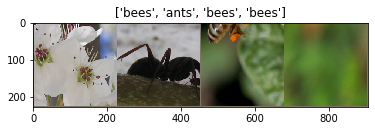

In [22]:
imshow(out, title = [class_names[x] for x in classes])

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [25]:
model_ft = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/rohit/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [26]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

In [27]:
model_ft = model_ft.to(device)

In [28]:
criterion = nn.CrossEntropyLoss()

In [29]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

In [31]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.5330 Acc: 0.7131
val Loss: 0.3386 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.5657 Acc: 0.7828
val Loss: 0.2557 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.5620 Acc: 0.7828
val Loss: 0.2442 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4160 Acc: 0.8566
val Loss: 0.2790 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.5312 Acc: 0.7992
val Loss: 0.2207 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.3817 Acc: 0.8443
val Loss: 0.3187 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.5036 Acc: 0.8115
val Loss: 0.2427 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3863 Acc: 0.8484
val Loss: 0.2675 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3014 Acc: 0.8689
val Loss: 0.2420 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.2911 Acc: 0.8770
val Loss: 0.2083 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2187 Acc: 0.9139
val Loss: 0.2093 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3220 Acc: 0.8607
val Loss: 0.2357 Acc: 0.8954

Ep

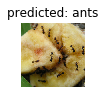

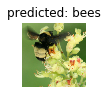

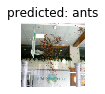

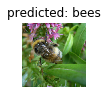

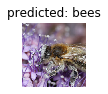

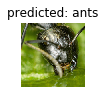

In [33]:
visualize_model(model_ft)

In [34]:
model_conv = torchvision.models.resnet18(pretrained = True)
for param in model_conv.parameters():
    param.requires_grad = False

In [35]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma = 0.1)



In [36]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.7599 Acc: 0.6148
val Loss: 0.2173 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.6059 Acc: 0.7418
val Loss: 0.1734 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.4678 Acc: 0.7869
val Loss: 0.2403 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.5612 Acc: 0.7787
val Loss: 0.1744 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4134 Acc: 0.8320
val Loss: 0.3237 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.5191 Acc: 0.7910
val Loss: 0.1758 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4601 Acc: 0.8074
val Loss: 0.1795 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.2714 Acc: 0.8648
val Loss: 0.1804 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3803 Acc: 0.8361
val Loss: 0.1879 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3252 Acc: 0.8607
val Loss: 0.1750 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3423 Acc: 0.8525
val Loss: 0.1762 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3103 Acc: 0.8566
val Loss: 0.1676 Acc: 0.9477

Ep

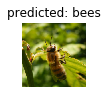

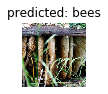

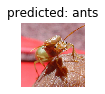

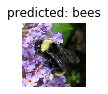

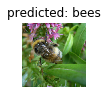

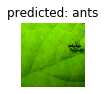

In [37]:
visualize_model(model_conv)